<a href="https://colab.research.google.com/github/nathanielborland/2024Fall-MOCS/blob/main/Assignment2CellularAutomata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment #2**
Carina Manitius, Trevor Webster, Derek Devine, Nate Borland

# City Growth

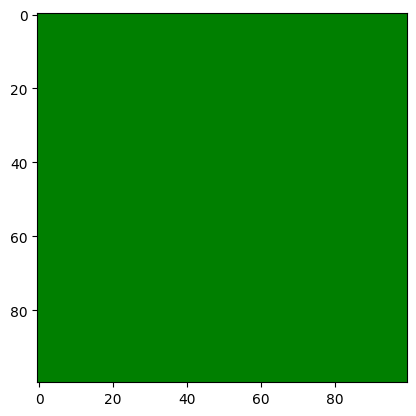

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
import time

# length of one side of the world grid. world will be a (world_size x world_size) 2D array.
size = 100 # @param {type:"slider", min:0, max:111, step:1}

# default chance for green space to turn into urban space for a certain number of urban neighbors
default_chance_0 = 0.05 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_1 = 0.1 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_2 = 0.2 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_3 = 0.3 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_4 = 0.4 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_5 = 0.4 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_6 = 0.5 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_7 = 0.5 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_8 = 0.3 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_9 = 0.2 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_10 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_11 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_12 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_13 = 0 # @param {type:"slider", min:0, max:1, step:0.001}
default_chance_14 = 0 # @param {type:"slider", min:0, max:1, step:0.001}

# list of default urbanization chances
default_chances = [default_chance_0, default_chance_1, default_chance_2,
                   default_chance_3, default_chance_4, default_chance_5,
                   default_chance_6, default_chance_7, default_chance_8,
                   default_chance_9, default_chance_10, default_chance_11,
                   default_chance_12, default_chance_13, default_chance_14]

# radius of the extended moore neighborhood considered for each cell update
# compute used increases drastically as this increases
r = 1 # @param {type:"slider", min:1, max:3, step:1}

max_unchanged_updates = 5 # @param {type:"slider", min:1, max:10, step:1}

# toggles display of intermediate steps, disabling will skip to the end state and is much faster
animate_growth = True # @param {type:"boolean"}

# forced sleep on every update, for slowing down animations for very fast rule sets
forced_sleep = 0 # @param {type:"slider", min:0, max:1, step:0.1}

# displays the current state of world cells
def display_world(world):
    plt.imshow(np.flipud(world), cmap=plt.get_cmap(cm.ocean))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# gets the square neighborhood within radius of the cell at i,j in world
# treats cells with i or j less than 0 or greater than world_size - 1 as 0
def get_neighborhood(world, i, j):
    # WIP better rules that treat indices outside the world as 0, not working
    neighborhood = np.zeros(((r*2)+1,(r*2)+1))
    for k in range(i-r, i+r+1):
        for l in range(j-r, j+r+1):
            if not (k < 0 or l < 0 or k > size-1 or l > size-1):
                neighborhood[k-(i-r)][l-(j-r)] = world[k][l]
    return neighborhood

## Explicit zoning rules for each neighbor count
def get_next_state(neighborhood):
    chance = default_chances[min(len(default_chances)-1, np.count_nonzero(neighborhood))]
    if chance > 0 and np.random.rand() < chance:
        return 1
    else:
        return 0

# checks each cell in world and applies the results of get_next_state
def update_world(world):
    next_world = world.copy()
    for i in range(size):
        for j in range(size):
            # urban space cannot turn into green space in this model so we can skip it
            if world[i][j] == 1:
                continue
            next_world[i][j] = get_next_state(get_neighborhood(world, i, j))
    return next_world

# set up 'world', a (size x size) 2D array of all zeros (green space)
world = np.zeros((size,size))
# set up a single 1 (urban space) in the center
world[size//2,size//2] = 1

# set up completion conditions
finished = False
force_sleep = forced_sleep > 0
num_unchanged_updates = 0

# main update loop
while not finished:
    # display current world state
    if animate_growth:
        display_world(world)
        if force_sleep:
            time.sleep(forced_sleep)
    # compute next world state
    next_world = update_world(world)
    # check if world changed in the last update
    if np.array_equal(world, next_world):
        num_unchanged_updates += 1
    else:
        num_unchanged_updates = 0
    # check if world is sufficiently settled
    if num_unchanged_updates > max_unchanged_updates:
        finished = True
    # update world state
    world = next_world

# display final state of the world
display_world(world)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 0. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


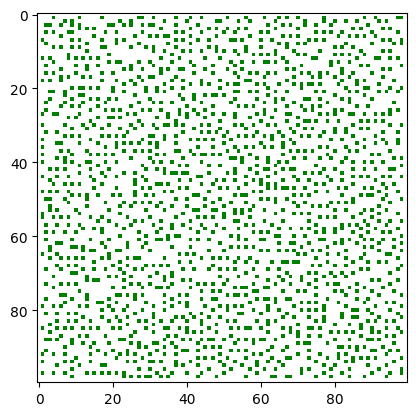

In [4]:
## Random Moore Neighboorhood Uniform Probabilities Hard Caps after neighbor 7
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display

import time

# special rule indexing schema
# number indicates bit offset from the right
# + or - indicates center being 1 or 0, respectively
# [ 0 ][ 1 ][ 2 ]
# [ 3 ][+/-][ 4 ]
# [ 5 ][ 6 ][ 7 ]
# for byte with bit indices 76543210
# bit indices count right to left, which is confusing
# neighbor indices go left to right, top to bottom
#
# for example
# 97 = 01100001
# [ 1 ][ 0 ][ 0 ]
# [ 0 ][ 1 ][ 0 ]
# [ 1 ][ 1 ][ 0 ]
#
# -174 = -10101110
# [ 0 ][ 1 ][ 1 ]
# [ 1 ][ 0 ][ 0 ]
# [ 1 ][ 0 ][ 1 ]

# special rule types & values
two_opposing = 0

# each rule here sets a specific chance for specific orientations (only works on moore neighborhood radius 1)
# a rule number can be calculated by adding up the values in each square below
# indices by decimal value
# [ 1 ][ 2 ][ 4 ]
# [ 8 ][*-1][ 16]
# [ 32][ 64][128]
# ex: a rule for the top right and bottom left being active would be 4 + 32 = 36
# ex: a rule for all 3 bottom cells being active would be 32 + 64 + 128 = 224
#
# current rule set: each combination of exactly two neighbors that are not adjacent (diagonals not considered adjacent here) uses the two_opposing chance defined above as 0
special_rule_dict = {
# 1 + opposite corner
    5 : two_opposing,
    33 : two_opposing,
    65 : two_opposing,
    129 : two_opposing,
    17 : two_opposing,
# 2 + opposite side
    10 : two_opposing,
    34 : two_opposing,
    66 : two_opposing,
    130 : two_opposing,
    18 : two_opposing,
# 4 + opposite corner
    5 : two_opposing,
    12 : two_opposing,
    36 : two_opposing,
    68 : two_opposing,
    132 : two_opposing,
# 8 + opposite side
    24 : two_opposing,
    136 : two_opposing,
    72 : two_opposing,
# 16 + opposite side
    48 : two_opposing,
    80 : two_opposing,
# 32 + opposite side
    160 : two_opposing,
}

world_size = 100 # @param {type:"slider", min:0, max:111, step:1}

# default chance to turn into a city for each possible number of city neighbors
default_chance_0 = 1/7 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_1 = 1/7 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_2 = 1/7 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_3 = 1/7 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_4 = 1/7 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_5 = 1/7 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_6 = 1/7 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_7 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_8 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_9 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_10 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_11 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_12 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_13 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_14 = 0 # @param {type:"slider", min:0, max:1, step:0.01}

# list of default urbanization chances
default_chances = [default_chance_0, default_chance_1, default_chance_2,
                   default_chance_3, default_chance_4, default_chance_5,
                   default_chance_6, default_chance_7, default_chance_8,
                   default_chance_9, default_chance_10, default_chance_11,
                   default_chance_12, default_chance_13, default_chance_14]

# radius of the neighborhood considered for each cell update
# compute used increases drastically as this increases
neighborhood_radius = 1 # param {type:"slider", min:0, max:5, step:1}

# toggles use of the special_rule_dict, disabling will default to basic neighbor count rules
use_special_rules = False # @param {type:"boolean"}

# toggles display of intermediate steps, disabling will skip to the end state and is much faster
animate_growth = True # @param {type:"boolean"}

# forced sleep on every update, for slowing down animations for very fast rule sets
forced_sleep = 0 # param {type:"slider", min:0, max:1, step:0.1}

# r_growth_rate = 1 # @param {type:"slider", min:0, max:1, step:0.01}
# K = 9 - 1

# displays the current state of world cells
def display_world(world):
    plt.imshow(np.flipud(world), cmap=plt.get_cmap(cm.ocean))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# gets the square neighborhood within radius of the cell at i,j in world
# treats cells with i or j less than 0 or greater than world_size - 1 as 0
def get_neighborhood(world, i, j):
    # WIP better rules that treat indices outside the world as 0, not working
    neighborhood = np.zeros(((neighborhood_radius*2)+1,(neighborhood_radius*2)+1))
    for k in range(i-neighborhood_radius, i+neighborhood_radius+1):
        for l in range(j-neighborhood_radius, j+neighborhood_radius+1):
            if not (k < 0 or l < 0 or k > world_size-1 or l > world_size-1):
                neighborhood[k-(i-neighborhood_radius)][l-(j-neighborhood_radius)] = world[k][l]
    return neighborhood

# def logistic_rule(neighbor_count):
#     return np.random.rand() < r_growth_rate * (1 - (neighbor_count/K))

# helper function to get a rule number for a given neighborhood
def get_rule_num(neighborhood):
    rule_num = 0
    if neighborhood[neighborhood_radius-1,neighborhood_radius-1] == 1:
        rule_num = rule_num | 1 << 0
    if neighborhood[neighborhood_radius-1,neighborhood_radius] == 1:
        rule_num = rule_num | 1 << 1
    if neighborhood[neighborhood_radius-1,neighborhood_radius+1] == 1:
        rule_num = rule_num | 1 << 2
    if neighborhood[neighborhood_radius,neighborhood_radius-1] == 1:
        rule_num = rule_num | 1 << 3
    if neighborhood[neighborhood_radius,neighborhood_radius+1] == 1:
        rule_num = rule_num | 1 << 4
    if neighborhood[neighborhood_radius+1,neighborhood_radius-1] == 1:
        rule_num = rule_num | 1 << 5
    if neighborhood[neighborhood_radius+1,neighborhood_radius] == 1:
        rule_num = rule_num | 1 << 6
    if neighborhood[neighborhood_radius+1,neighborhood_radius+1] == 1:
        rule_num = rule_num | 1 << 7
    if neighborhood[neighborhood_radius,neighborhood_radius] == 0:
        rule_num *= -1
    return rule_num

## Explicit zoning rules for each neighbor count
def get_next_state(neighborhood):
    rule_num = get_rule_num(neighborhood)
    default_chance = default_chances[min(len(default_chances)-1, np.count_nonzero(neighborhood))]

    # tweak as needed to modify how priority works between default and special rules
    # this should only be relevant for neighborhoods with radius > 1
    if use_special_rules and rule_num in special_rule_dict:
        chance = special_rule_dict[rule_num]
    else:
        chance = default_chance

    if chance > 0 and np.random.rand() < chance:
        return 1
    else:
        return 0

# checks each cell in world and applies the results of get_next_state
def update_world(world):
    next_world = world.copy()
    reached_edge = False
    for i in range(world_size):
        for j in range(world_size):
            # this saves compute but must be removed if we want city to be able to turn to forest
            if world[i][j] == 1:
                continue
            next_state = get_next_state(get_neighborhood(world, i, j))
            next_world[i][j] = next_state
            if next_state == 1 and (i == 0 or j == 0 or i == world_size-1 or j == world_size-1):
                reached_edge = True

    return (next_world, reached_edge)

# set up 'world', a (size x size) 2D array of all zeros (greenspace) with a 1 (concrete) in the center
world = np.zeros((world_size,world_size))
world[world_size//2,world_size//2] = 1

# set up completion conditions
finished = False
reached_edge = False
num_unchanged_updates = 0
max_unchanged_updates = 10

# main update loop
while not finished:
    if animate_growth:
        display_world(world)
        # uncomment to slow down very fast rulesets
        # time.sleep(0.1)

    (next_world, touched_edge) = update_world(world)

    if np.array_equal(world, next_world):
        num_unchanged_updates += 1
    else:
        num_unchanged_updates = 0

    # tweaks to completion conditions go here
    if touched_edge:
        reached_edge = True
    if reached_edge and num_unchanged_updates > max_unchanged_updates:
        finished = True
    world = next_world

# display final state of the world
display_world(world)
print(world)

In [38]:
print(world)
4+2+5+2+3+1+1+5

[[0. 0. 1. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


23

In [5]:
import numpy as np

def divide_into_boxes(arr, r):
    # Get the size of the original array
    n = arr.shape[0]
    arr = np.array(arr)
    if n % r != 0:
        raise ValueError("The size of the array must be divisible by the block size.")

    # Reshape and swap axes to divide the array into r x r boxes
    boxes = arr.reshape(n // r, r, n // r, r).swapaxes(1, 2)
    return boxes

# Counts number of boxes of size r to cover the structure 
def box_count(arr, r):
    N = 0
    boxes = divide_into_boxes(arr, r)
    for i in range(boxes.shape[0]):
        for j in range(boxes.shape[1]):
            # print(f"Box ({i}, {j}):")
            # print(boxes[i, j])
            # print()
            if np.any(boxes[i,j]==1):
                N += 1
      
        
    return N

# Counts boxes to cover structure for all r divisors
def box_count_all_r(world):
    res = []
    arr = world
    n = world.shape[0]
    divisors = [r for r in range(1, n+1) if n % r == 0]
    for r in divisors:
        N = box_count(arr,r)
        res.append((r, r/N, N ))
    return res

# Example usage


res = (box_count_all_r(world))
print(res)
# boxes = divide_into_boxes(arr, r)

# # Print the resulting blocks
# print(boxes)

# print(f"Shape of blocks: {boxes.shape}")
# print(box_count(arr, r))


[(1, 0.00012128562765312311, 8245), (2, 0.0008, 2500), (4, 0.0064, 625), (5, 0.0125, 400), (10, 0.1, 100), (20, 0.8, 25), (25, 1.5625, 16), (50, 12.5, 4), (100, 100.0, 1)]


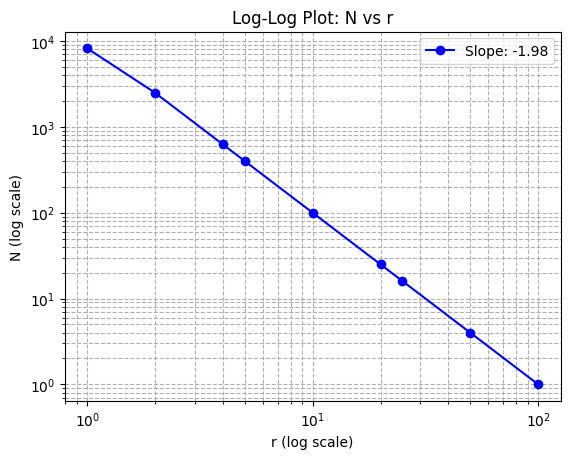

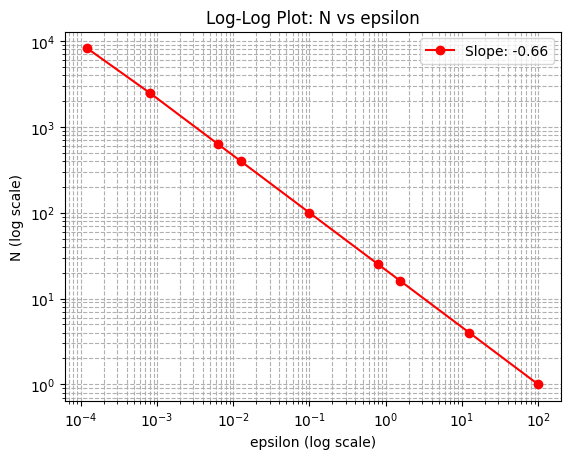

(-1.97588268146259, -0.6640113452940893)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Data: (r, epsilon, N)

# Extracting the columns into individual arrays
r = np.array([x[0] for x in res])
epsilon = np.array([x[1] for x in res])
N = np.array([x[2] for x in res])

def plot_with_slope(x, y, xlabel, ylabel, title, color='b'):
    # Perform log-log regression to calculate slope
    slope, intercept = np.polyfit(np.log10(x), np.log10(y), 1)
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.loglog(x, y, marker='o', linestyle='-', color=color, label=f'Slope: {slope:.2f}')
    ax.set_xlabel(f'{xlabel} (log scale)')
    ax.set_ylabel(f'{ylabel} (log scale)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--")
    return fig, slope

# Create both plots with slopes
fig1, slope1 = plot_with_slope(r, N, 'r', 'N', 'Log-Log Plot: N vs r', 'b')
fig2, slope2 = plot_with_slope(epsilon, N, 'epsilon', 'N', 'Log-Log Plot: N vs epsilon', 'r')

# Display plots
plt.show()

# Print slopes for reference
slope1, slope2


In [1]:
from scipy.ndimage import label

def biggest_greenspace(world):
    # Using scipy's label function to identify contiguous clusters of 0's (greenspace)
    labeled_world, num_features = label(world == 0)

    if num_features == 0:
        return  # If no clusters, exit function

    # Find the size of each cluster
    sizes = np.bincount(labeled_world.ravel())

    # Find the label corresponding to the largest cluster
    largest_cluster_label = np.argmax(sizes[1:]) + 1

    # Create an array where only the largest cluster is marked
    largest_cluster = (labeled_world == largest_cluster_label).astype(int)

    # Plot the largest cluster of 0's (greenspace)
    plt.figure()
    plt.imshow(np.flipud(largest_cluster), cmap=plt.get_cmap('Greens'))
    plt.show()

largest_cluster_size = biggest_greenspace(world)



NameError: name 'world' is not defined

# Greenspace metrics

In [18]:
from scipy.ndimage import label

# 1. Metric: share_greenspace (% of greenspace cells)
def share_greenspace(world):
    total_cells = size * size
    greenspace_cells = np.sum(world == 0)
    return greenspace_cells / total_cells

# 2. Metric: biggest_greenspace (largest cluster of contiguous greenspace cells)
def biggest_greenspace(world):
    # Using scipy's label function to identify contiguous clusters of 0's (greenspace)
    labeled_world, num_features = label(world == 0)
    if num_features == 0:
        return 0
    # Find the size of each cluster and return the largest
    sizes = np.bincount(labeled_world.ravel())
    return sizes[1:].max()  # exclude the background (index 0)

# 3. Metric: access_greenspace (urban cells bordering greenspace)
def access_greenspace(world):
    access_count = 0
    total_urban_cells = np.sum(world == 1)  # count the number of urban cells
    for i in range(size):
        for j in range(size):
            if world[i][j] == 1:  # only look at urban cells
                # Get von Neumann neighborhood (up, down, left, right)
                neighbors = [
                    (i-1, j),  # up
                    (i+1, j),  # down
                    (i, j-1),  # left
                    (i, j+1)   # right
                ]
                for ni, nj in neighbors:
                    if 0 <= ni < size and 0 <= nj < size and world[ni][nj] == 0:
                        access_count += 1
                        break  # no need to check further if greenspace is found

    if total_urban_cells == 0:
        return 0  # avoid division by zero if there are no urban cells

    return access_count / total_urban_cells  # return percentage

# 4. Metric: average_greenspace (average size of greenspace clusters)
def average_greenspace(world):
    labeled_world, num_features = label(world == 0)
    if num_features == 0:
        return 0
    # Find the size of each cluster
    sizes = np.bincount(labeled_world.ravel())
    return sizes[1:].mean()  # exclude the background (index 0)

# Compute and display the metrics
final_share_greenspace = share_greenspace(world)
final_biggest_greenspace = biggest_greenspace(world)
final_access_greenspace = access_greenspace(world)
final_average_greenspace = average_greenspace(world)

print(f"Share of Greenspace: {final_share_greenspace:.2%}")
print(f"Largest Greenspace Cluster: {final_biggest_greenspace} cells")
print(f"Percentage of Urban Cells with Greenspace Access: {final_access_greenspace:.2%}")
print(f"Average Greenspace Cluster Size: {final_average_greenspace:.2f} cells")

Share of Greenspace: 55.32%
Largest Greenspace Cluster: 170 cells
Percentage of Urban Cells with Greenspace Access: 98.88%
Average Greenspace Cluster Size: 11.60 cells


# Loop runs and collect metrics

In [47]:
# Number of simulation runs
num_runs = 100  # Change this to the desired number of runs

# Initialize lists to store metrics for each run
share_greenspace_list = []
biggest_greenspace_list = []
access_greenspace_list = []
average_greenspace_list = []

# Run the simulation multiple times
for run in range(num_runs):
    # Reset world for each run
    world = np.zeros((size, size))
    world[size // 2, size // 2] = 1  # starting condition with one urban cell in the center

    finished = False
    reached_edge = False

    # Main update loop for the simulation
    while not finished:
        (next_world, touched_edge) = update_world(world)

        if touched_edge:
            reached_edge = True
        if reached_edge and np.array_equal(world, next_world):
            finished = True
        world = next_world

    # Compute metrics for the final state of the world
    final_share_greenspace = share_greenspace(world)
    final_biggest_greenspace = biggest_greenspace(world)
    final_access_greenspace = access_greenspace(world)  
    final_average_greenspace = average_greenspace(world)

    # Append metrics to their respective lists
    share_greenspace_list.append(final_share_greenspace)
    biggest_greenspace_list.append(final_biggest_greenspace)
    access_greenspace_list.append(final_access_greenspace)
    average_greenspace_list.append(final_average_greenspace)

# Calculate averages of the metrics
average_share_greenspace = np.mean(share_greenspace_list)
average_biggest_greenspace = np.mean(biggest_greenspace_list)
average_access_greenspace = np.mean(access_greenspace_list)
average_average_greenspace = np.mean(average_greenspace_list)

# Print the average metrics across all runs
print(f"Average Share of Greenspace: {average_share_greenspace:.2%}")
print(f"Average Largest Greenspace Cluster: {average_biggest_greenspace:.2f} cells")
print(f"Average Percentage of Urban Cells with Greenspace Access: {average_access_greenspace:.2%}")
print(f"Average Greenspace Cluster Size: {average_average_greenspace:.2f} cells")

Average Share of Greenspace: 42.73%
Average Largest Greenspace Cluster: 47.83 cells
Average Percentage of Urban Cells with Greenspace Access: 88.81%
Average Greenspace Cluster Size: 4.57 cells


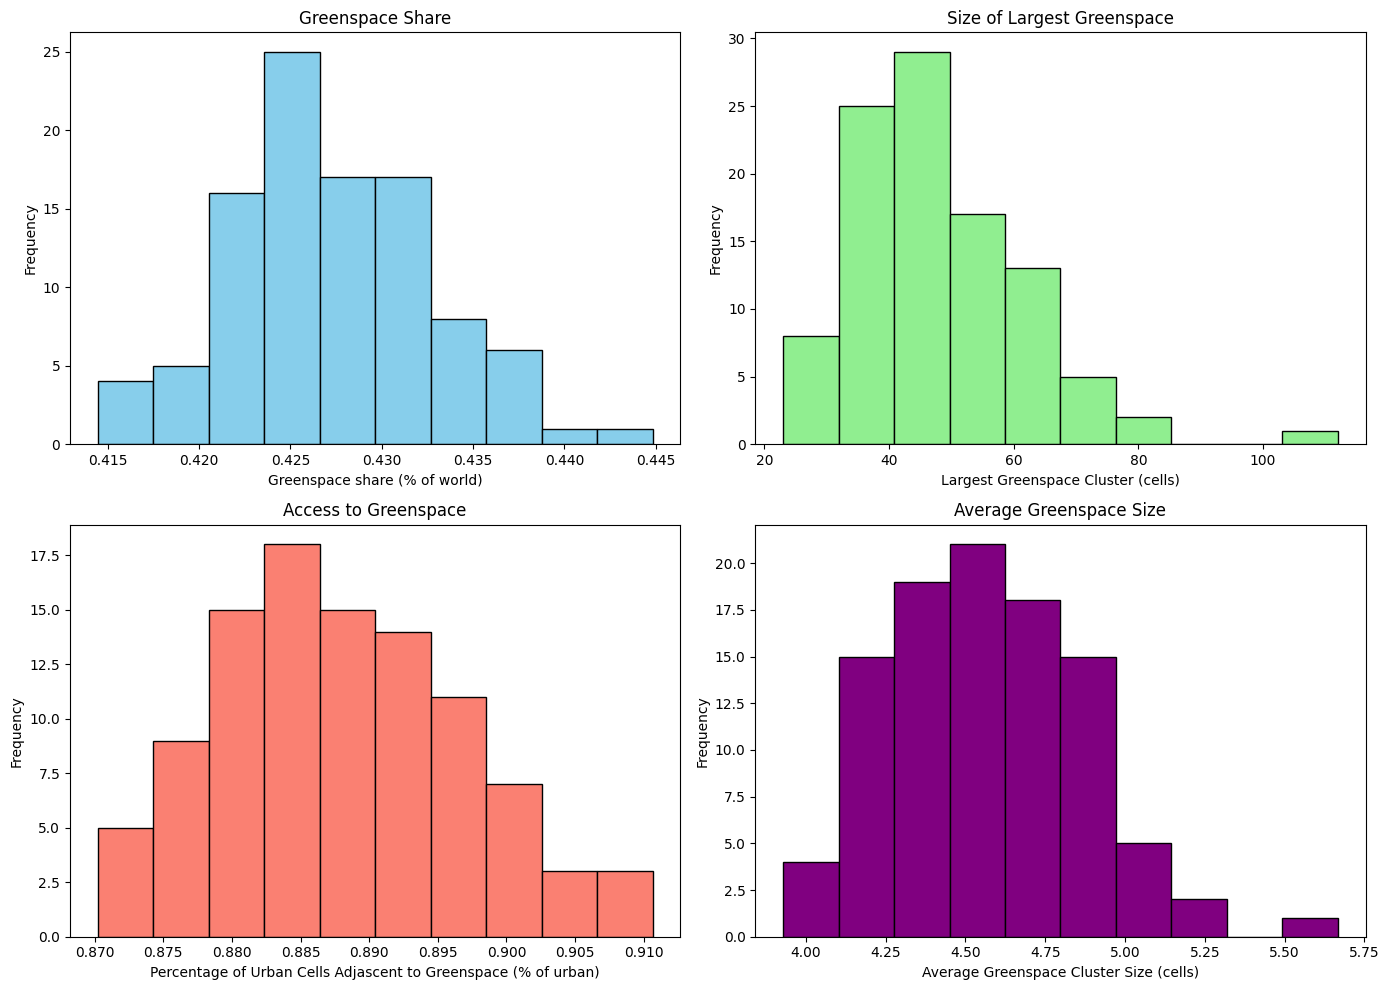

In [48]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import random

# Share of Greenspace
plt.subplot(2, 2, 1)
plt.hist(share_greenspace_list, bins=10, color='skyblue', edgecolor='black')
plt.title('Greenspace Share')
plt.xlabel('Greenspace share (% of world)')
plt.ylabel('Frequency')

# Parameters
N, S, K, steps = 32, 2, 3, 32 #size, states, neighbors, steps
rule = 30 #rule number
tape = np.zeros(N) #initial conditions of zero
tape[N//2] = 1 #initial conditions
#tape = np.random.randint(2, size=N) #random initial conditions

# Run the CA
#tapes = run_1d_CA(steps,tape)
#tapes = run_rule_30(steps,tape)
tapes = run_cellauto(S, K, decode_rule(rule, S, K), steps, tape) #run model

# Average Greenspace Cluster Size
plt.subplot(2, 2, 4)
plt.hist(average_greenspace_list, bins=10, color='purple', edgecolor='black')
plt.title('Average Greenspace Size')
plt.xlabel('Average Greenspace Cluster Size (cells)')
plt.ylabel('Frequency')

# Add rule label
#ax.text(2, steps+0.5, f'Cellular automaton', color='Orange', fontsize=20)
ax.text(2, steps+0.5, f'Rule {rule}', color='Orange', fontsize=20)
plt.show()